In [94]:
import glob
import sys
import numpy as np
import operator
from scipy import optimize
from scipy import stats
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import RegularGridInterpolator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

In [95]:
def kappa(b,s,alpha,r):
    return b*alpha*((s*s+r*r)**(alpha/2-2))*((s*s+r*r)+r*r*(alpha/2-1))

def gamma(b,s,alpha,r):
    return b*alpha*((s*s+r*r)**(alpha/2-2))*((alpha/2-1)*r*r)

def muinv(b,s,alpha,r):
    return (1-kappa(b,s,alpha,r)+gamma(b,s,alpha,r))*(1-kappa(b,s,alpha,r)-gamma(b,s,alpha,r))

In [96]:
alpha=0.45
b=10.0

s = np.linspace(0.1, 3.5, 1000)
r = np.linspace(0.1, 3.5, 1000)
S, R = np.meshgrid(s, r)
Zk=kappa(b,S,alpha,R)
Zg=gamma(b,S,alpha,R)
Zm=1/muinv(b,S,alpha,R)

<ipython-input-4-c20f50d9793e>:4: RuntimeWarning: invalid value encountered in log10
  im=ax.contour(S,R,np.log10(Zm),cmap='magma')


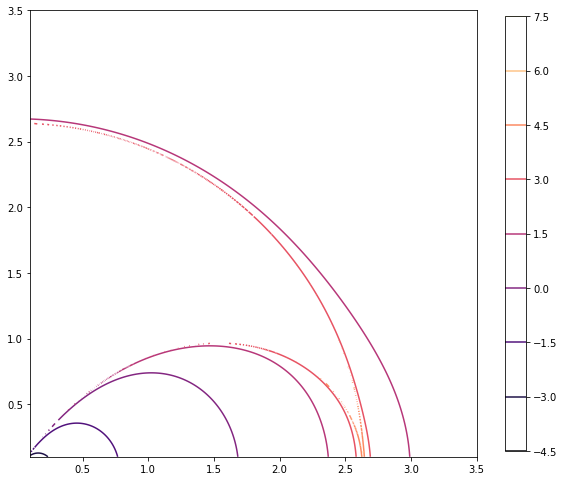

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
# im=ax.pcolormesh(S,R,np.log10(Zm),vmax=6,vmin=0,cmap='inferno')
im=ax.contour(S,R,np.log10(Zm),cmap='magma')
fig.colorbar(im, ax=ax, shrink=0.8)


/Users/agnivaghosh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


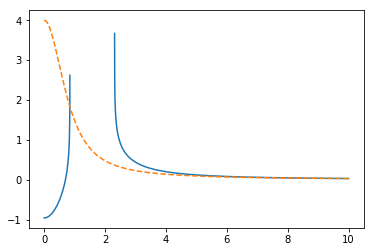

In [274]:
R = np.linspace(0, 10, 10000)
alpha=0.5
# plt.plot(R,np.log10(1/muinv(2,1,alpha,R)))
plt.plot(R,np.log10(1/muinv(8,1,alpha,R)))
plt.plot(R,kappa(8,1,alpha,R),'--')

In [35]:
alpha=0.5

r = np.linspace(0.1, 100, 1000)
s = np.linspace(0.1, 10, 100)
b = np.linspace(0.1, 10, 100)
S, B = np.meshgrid(s, b)
mass = np.zeros([1000,100,100])
masssum = np.zeros([1000,100,100])
for i in range(1000):
    mass[i,:,:]=kappa(B,S,alpha,r[i])
    masssum[i,:,:]=masssum[i-1,:,:]+mass[i,:,:]

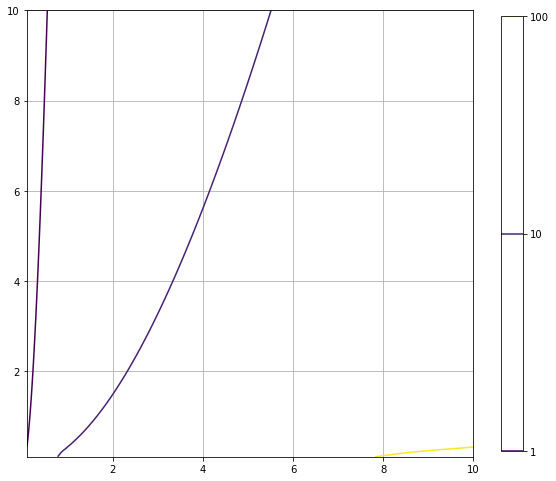

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
# im=ax.pcolormesh(S,B,np.log10(Zm),cmap='inferno')
im=ax.contour(B,S,masssum[999,:,:],[1,10,100])
fig.colorbar(im, ax=ax, shrink=0.8)

plt.grid(b=True)

In [9]:
np.shape(Zk)

(1000, 1000)

In [13]:
import glob
import sys
import numpy as np
import operator
from scipy import optimize
from scipy import stats
from scipy.ndimage import gaussian_filter
import math
from scipy.interpolate import RegularGridInterpolator

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds


zs=np.linspace(0.5,9,50)
N=len(zs)
def defl(image, scrit, sden, N, x, y):
    '''
    This function calculates the deflection angle at a point from a NxN grid. 
    image :: point to calculate deflection angle at
    scrit :: critical surface density at that point
    sden :: NxN grid of surface density points in units of kg/m^2
    x & y :: coordinates of grid with respect to center of cluster from Grale
    dfx & dfy :: components of deflection angle
    '''
    sd=0.1/scrit  #calculate reciprocal of critical surface density switching to kg/m^2


    #declare integrand for 2D integral
    intx,inty = np.meshgrid(x,y)
    dl=x[1]-x[0] #calculate integration step between grid points

    dfx = 0. #initialize each component of deflection angle
    dfy = 0. 

    # construct 2-D integrands
    #---------------------------------------------------------------------
    for j in range(N):
        for i in range(N):
            d = np.sqrt((image[0]-x[i])**2+(image[1]-y[j])**2)
            dfx += (image[0]-x[i])*sden[j,i]*sd/d**2/np.pi*dl*dl
            dfy += (image[1]-y[j])*sden[j,i]*sd/d**2/np.pi*dl*dl

    return dfx, dfy


################
class constants:
#---------------
	'''
	class of cosmology constants
	'''
    ##########################################
	def __init__(self, omega_m, omega_l, H_0):
    #-----------------------------------------
		self.omega_m = omega_m 					#matter density
		self.omega_l = omega_l					#dark energy density / lambda
		self.omega_k = 1.0 - omega_l - omega_m 	#curvature density, for flat normally zero
		self.H = H_0						#Hubble parameter today
		self.h = H_0/100.					#dimensionless Hubble parameter
		self.d_h = 299792.458/H_0			#Hubble distance, c/H_0 with c in units of km * s^-1


################
class distances:
#---------------
	'''
	class of different distances in cosmology
	'''
    ################################
	def codist(self, z1, z2, cosmo):
    #-------------------------------
		'''
		This function calculates the comoving distance d_c in units of Mpc.
		z1, z2 :: redshifts with z1<z2
		cosmo  :: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c    :: comoving distance
		'''
		dz = 0.0001
		z = z1 + 0.5 * dz
		d_c = 0.0
		while(z < z2):
			f = 1.0 + z
			demon = cosmo.omega_m * f**3 + cosmo.omega_k * f**2 + cosmo.omega_l
			d_c += dz / np.sqrt(demon)
			z += dz
		return d_c*cosmo.d_h
    ######################################
	def tcodist(self, z1, z2, d_c, cosmo):
    #-------------------------------------
		'''
		This function calculates the transverse comoving distance d_M in units of Mpc.
		z1, z2	:: redshifts with z1<z2
		cosmo	:: class of cosmology constants (omega_m, omega_l, h, etc.)
		d_c		:: comoving distance
		d_M		:: transverse comoving distance
		'''
		d_M = 0.0
		f = np.sqrt(np.abs(cosmo.omega_k))
		if(cosmo.omega_k > 0.0):
			d_M = cosmo.d_h/f*np.sinh(f*d_c/cosmo.d_h)
			#print 'Omega_k > 0'
		elif(cosmo.omega_k < 0.0):
			d_m = cosmo.d_h/f*np.sin(f*d_c/cosmo.d_h)
			#print 'Omega_k < 0'
		else:
			d_M = d_c
		return d_M
    ###############################
	def angdist(self, d_M, z, d_A):
    #------------------------------
		'''
		This function calculates the angular diameter distance d_M in units of Mpc.
		z1		:: redshift z
		d_M		:: transverse comoving distance
		d_A		:: angular diameter distance
		'''
		d_A = 0.0
		d_A = d_M/(1.0+z)
		return d_A
    
# First thing is to get angular diameter distances and critical surface densities for every image

#Constants
c = 2.9979e10 #speed of light
G = 6.6726e-8 #Gravitational constant in cgs
m_sol = 1.989e33 #Solar mass in grams
rad_arcs = 206264.806 #Conversion factor for going from radians to arcseconds

# Define cosmology.
cosmo = constants(0.3, 0.7, 70)

# Define redshifts
z_o = 0.0  # observer redshift
z_l = 0.4  # lens redshift for Abell 2744

# Initialize angular diameter arrays
d_ol = np.zeros(N)
d_ls = np.zeros(N)
d_os = np.zeros(N)
scrit = np.zeros(N)

#Check Curvature is near zero
print ("Omega_k: ", cosmo.omega_k)

d_c, d_M, d_A = 0.0, 0.0, 0.0  # Initialize distances
dist = distances()  # create cosmology.distance instance

# For loop over images to calculate the angular diameter distances and critical surface densities.
for i in range(N):
    z_s = zs[i]

    # Calculate the observer to lens ang dist.
    d_c = dist.codist(z_o, z_l, cosmo)
    d_M = dist.tcodist(z_o, z_l, d_c, cosmo)
    d_A = dist.angdist(d_M, z_l, d_A)

    d_ol[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the lens to source ang dist.
    d_c = dist.codist(z_l, z_s, cosmo)
    d_M = dist.tcodist(z_l, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_ls[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    # Calculate the observer to source ang dist.
    d_c = dist.codist(z_o, z_s, cosmo)
    d_M = dist.tcodist(z_o, z_s, d_c, cosmo)
    d_A = dist.angdist(d_M, z_s, d_A)

    d_os[i] = d_A * 3.08567758e24  # Convert from Mpc to cm

    #Calculate critical surface density
    scrit[i] = c**2/(4*np.pi*G)*d_os[i]/d_ol[i]/d_ls[i]
    
print(scrit)





1000

3.187103317177062
3.311936592778542
3.594742376481362
4.002165263440689
4.500487073224884
[3.18710332 3.31193659 3.59474238 4.00216526 4.50048707]


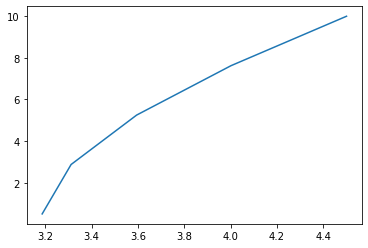

In [911]:
alpha=1
s = np.linspace(0.5, 10, 5)
r = np.linspace(0, 10, 1000)
# k=np.zeros(len(s))
b=np.zeros(len(s))
for j in range(len(s)):
    k=np.sum(r[:]*2*3.14*(r[1]-r[0])*alpha*((s[j]*s[j]+r[:]*r[:])**(alpha/2-2))*((s[j]*s[j]+r[:]*r[:])+r*r*(alpha/2-1)))/100 #needs summation over mass
    print(1/k)
    b[j]=1/k
print(b)
plt.plot(b,s)

In [912]:
(r[1]-r[0])

0.01001001001001001

In [913]:
def muinv(b,s,alpha,r,scale):
    return (1-scale*kappa(b,s,alpha,r)+scale*gamma(b,s,alpha,r))*(1-scale*kappa(b,s,alpha,r)-scale*gamma(b,s,alpha,r))

In [925]:
scale=1/scrit
rsq=np.linspace(1, 10000, 10000)
mu = np.zeros([len(rsq),len(s),len(b),len(scale)])
for k in range(len(scale)):
    for i in range(len(rsq)):
        mu[i,:,:,k]=1/muinv(b,s,alpha,rsq[i]**0.5,scale[k])

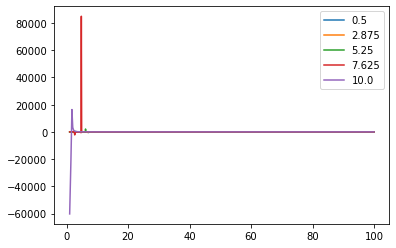

In [915]:
for i in range(len(s)):
    plt.plot(rsq**0.5,mu[:,i,i,9],label=s[i])
plt.legend(loc='upper right')

In [924]:
bins=np.zeros([len(scale),1000])
counts=np.zeros([len(scale),999])
area=np.zeros([len(scale),len(s)])
n_bins = np.linspace(1, 100, num=1000)
for k in range(len(scale)):
    for i in range(len(s)):
        counts[k], bins[k], what = plt.hist(mu[:,i,i,k],n_bins,cumulative=-1,density=True,histtype='step')
        area[k,i]=counts[k][192]
plt.yscale('log')
print(bins[1][192])

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fcf81dfc5e0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(s)):
    plt.plot(zs,area[:,i],label=s[i])
    plt.plot(zs,(5*10**24)*d_ls/d_ol/d_os,'--',color='black')
plt.legend()